# Human Activity Recognition
Credit to:
* https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
* https://github.com/cwi-dis/mobile-har-tutorial

In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut

from scipy import stats
import scipy.io

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm
import seaborn as sns
import pickle
import math
import os
# import wget
import zipfile
import warnings

In [2]:
## wget UCD dataset + all .npy files and dump into ./data dir

if not os.path.exists('./data'):
    os.makedirs('./data')

if not os.path.exists('./accel'):
    os.makedirs('./accel')

!wget -P ./data 'http://abdoelali.com/data/mobilehci2018_tutorial_data.zip'
!wget -P ./accel 'http://abdoelali.com/data/accel_only.zip'

--2024-02-10 16:15:54--  http://abdoelali.com/data/mobilehci2018_tutorial_data.zip
Resolving abdoelali.com (abdoelali.com)... 104.248.131.45
Connecting to abdoelali.com (abdoelali.com)|104.248.131.45|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://abdoelali.com/data/mobilehci2018_tutorial_data.zip [following]
--2024-02-10 16:15:54--  https://abdoelali.com/data/mobilehci2018_tutorial_data.zip
Connecting to abdoelali.com (abdoelali.com)|104.248.131.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273858391 (261M) [application/zip]
Saving to: ‘./data/mobilehci2018_tutorial_data.zip’

mobilehci2018_tutor 100%[===================>] 261.17M   200MB/s    in 1.3s    

2024-02-10 16:15:55 (200 MB/s) - ‘./data/mobilehci2018_tutorial_data.zip’ saved [273858391/273858391]

--2024-02-10 16:15:55--  http://abdoelali.com/data/accel_only.zip
Resolving abdoelali.com (abdoelali.com)... 104.248.131.45
Connecting to abdoelali.co

In [3]:
## unzip and delete files
with zipfile.ZipFile('./data/mobilehci2018_tutorial_data.zip','r') as zipref:
    zipref.extractall('./data/')
os.remove('./data/mobilehci2018_tutorial_data.zip')

with zipfile.ZipFile('./accel/accel_only.zip','r') as zipref:
    zipref.extractall('./accel/')
os.remove('./accel/accel_only.zip')

In [4]:
## let's first define some function we will use

## setting up a random seed for reproducibility
random_seed = 611
np.random.seed(random_seed)

## matplotlib inline
plt.style.use('ggplot')

## defining function for loading our dataset
def readData(filePath):
    # attributes of the dataset
    columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    return data[0:2000]

## feature normalization using standardization (or Z-score normalization)
## (feature - mean)/stdiv
def featureNormalizeZscore(data):
    mu = np.mean(data,axis=0)
    sigma = np.std(data,axis=0)
    return (data-mu)/sigma

# find the min and max values for each column
def dataset_minmax(data):
    minmax = list()
    for i in range(len(data[0])):
        col_values = [row[i] for row in data]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax
 
# rescale dataset columns to the range 0-1
def normalize_dataset(data, minmax):
    for row in data:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
            
## compute Euclidean Norm
def featureNormalizeEuclidean(data):
    return np.sqrt(sum(data^2))

## defining the function to plot a single axis data
def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)

## defining a function to plot the data for a given activity
def plotActivity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

## defining a window function for segmentation purposes
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)    

## our segmentation function to get streams of 90 samples in each timestep 
def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,6))
    labels= np.empty((0))
    subjects = np.empty((0))

    for (start, end) in windows(data['activity'],window_size):
        x = data['acc_x'][start:end]
        y = data['acc_y'][start:end]
        z = data['acc_z'][start:end]
        p = data['gyr_x'][start:end]
        q = data['gyr_y'][start:end]
        r = data['gyr_z'][start:end]

        if(len(data['activity'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z,p,q,r])])
            if labels is not None:
                labels = np.append(labels,stats.mode(data['activity'][start:end])[0][0])
            subjects = np.append(subjects,stats.mode(data['subject'][start:end])[0][0])
    return segments, labels, subjects

In [5]:
## read in the USC-HAD data. here we use activity number since activities have missing/incorrect labels
DIR = './data/USC-HAD/data/'

# activity = []
subject = []
# age = []
act_num = []
sensor_readings = []

def read_dir(directory):
    for path, subdirs, files in os.walk(DIR):
        for name in files:
            if name.endswith('.mat'):
                mat = scipy.io.loadmat(os.path.join(path, name))
#                 activity.append(mat['activity'])
                subject.extend(mat['subject'])
#                 age.extend(mat['age'])
                sensor_readings.append(mat['sensor_readings'])

                if mat.get('activity_number') is None:
                    act_num.append('11')
                else:
                    act_num.append(mat['activity_number'])
    return subject, act_num, sensor_readings

## Corrupt datapoint:
# act_num[258] = '11'            
subject, act_num, sensor_readings = read_dir(DIR)

In [6]:
## get acc + gyr sensor readings and put in df (dataframe)
acc_x = []
acc_y = []
acc_z = []
gyr_x = []
gyr_y = []
gyr_z = []

act_label = []
subject_id = []
df = None

for i in range(840):
    for j in sensor_readings[i]:   
        acc_x.append(j[0]) # acc_x
        acc_y.append(j[1]) # acc_y
        acc_z.append(j[2]) # acc_z
        gyr_x.append(j[3]) # gyr_x
        gyr_y.append(j[4]) # gyr_y
        gyr_z.append(j[5]) # gyr_z
        act_label.append(act_num[i])
        subject_id.append(subject[i])
        
df = pd.DataFrame({'subject':subject_id,'acc_x':acc_x,'acc_y':acc_y,'acc_z':acc_z,'gyr_x':gyr_x,'gyr_y':gyr_y,'gyr_z':gyr_z,'activity':act_label})                   

df = df[['subject','acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z','activity']]

df.loc[df['activity'] == '1', 'activity'] = 'Walking Forward'
df.loc[df['activity'] == '2', 'activity'] = 'Walking Left'
df.loc[df['activity'] == '3', 'activity'] = 'Walking Right'
df.loc[df['activity'] == '4', 'activity'] = 'Walking Upstairs'
df.loc[df['activity'] == '5', 'activity'] = 'Walking Downstairs'
df.loc[df['activity'] == '6', 'activity'] = 'Running Forward'
df.loc[df['activity'] == '7', 'activity'] = 'Jumping Up'
df.loc[df['activity'] == '8', 'activity'] = 'Sitting'
df.loc[df['activity'] == '9', 'activity'] = 'Standing'
df.loc[df['activity'] == '10', 'activity'] = 'Sleeping'
df.loc[df['activity'] == '11', 'activity'] = 'Elevator Up'
df.loc[df['activity'] == '12', 'activity'] = 'Elevator Down'

## pickle the df 
df.to_pickle('data/df.pkl')

## these are the 12 classes we want to recognize!
df['activity'].unique() 

## print size of dataset
print('df size ' + str(len(df)))

df size 2811490


In [7]:
## use only for collapsing / reducing output classes

# df2 = df

# df2.loc[df2['activity'] == 'Walking Forward', 'activity'] = 'Walking'
# df2.loc[df2['activity'] == 'Walking Left', 'activity'] = 'Walking'
# df2.loc[df2['activity'] == 'Walking Right', 'activity'] = 'Walking'

In [8]:
## inspect the dataframe
print(df[1:10])

  subject     acc_x     acc_y     acc_z     gyr_x      gyr_y     gyr_z  \
1       7  0.888076  0.425966 -0.211597 -8.287599 -11.061767  0.123535   
2       7  0.891510  0.425966 -0.211597 -8.287599 -11.061767  0.123535   
3       7  0.894944  0.429586 -0.211597 -0.789322  -1.004702 -0.025368   
4       7  0.891510  0.429586 -0.207937 -0.621181  -0.523508  0.196681   
5       7  0.894944  0.429586 -0.207937 -0.417196  -0.351597  0.132094   
6       7  0.891510  0.425966 -0.207937 -0.311717  -0.262703  0.098697   
7       7  0.894944  0.425966 -0.207937  0.072152  -0.208027  0.078155   
8       7  0.898378  0.425966 -0.207937  0.059232  -0.170776  0.064160   
9       7  0.894944  0.425966 -0.207937 -0.288966  -0.482402  0.053958   

        activity  
1  Elevator Down  
2  Elevator Down  
3  Elevator Down  
4  Elevator Down  
5  Elevator Down  
6  Elevator Down  
7  Elevator Down  
8  Elevator Down  
9  Elevator Down  


### Explore your dataset (through visualization)

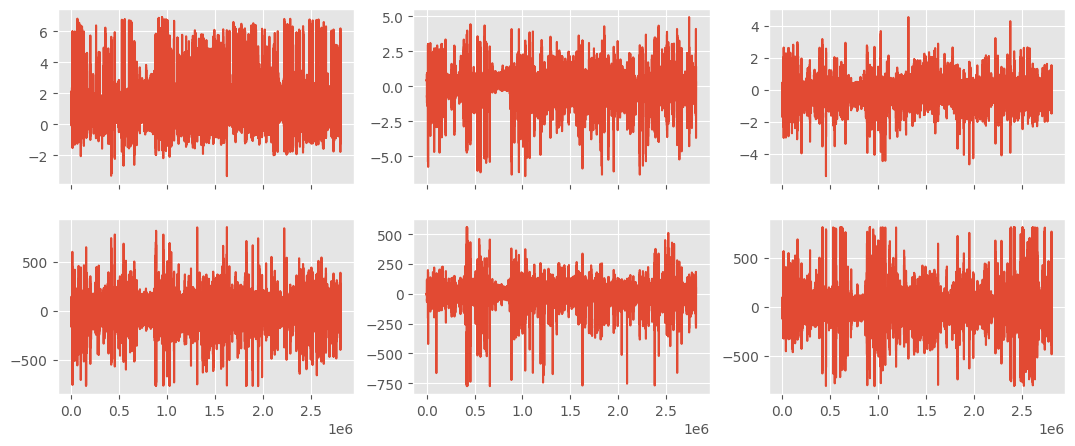

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z
count,2.811490e+06,2.811490e+06,2.811490e+06,2.811490e+06,2.811490e+06,2.811490e+06
mean,7.827995e-01,2.013366e-01,-6.190999e-02,-4.138871e-01,-3.517485e-01,-1.747959e-01
std,6.449592e-01,3.889872e-01,3.356888e-01,5.237366e+01,2.757491e+01,4.773775e+01
min,-3.352662e+00,-6.417827e+00,-5.416337e+00,-7.708486e+02,-7.754454e+02,-8.081837e+02
25%,6.168063e-01,-8.330392e-03,-2.445384e-01,-1.074605e+01,-6.752421e+00,-6.280653e+00
50%,8.812087e-01,2.305329e-01,-8.715175e-02,-5.208981e-02,-1.471133e-01,7.424915e-03
75%,9.807888e-01,4.332047e-01,1.104966e-01,9.589783e+00,4.131121e+00,7.904181e+00
max,6.931558e+00,4.949892e+00,4.539283e+00,8.563609e+02,5.596140e+02,8.165777e+02


In [9]:
## explore your overall accel and gyro values: min, max, mean, and plot over time

''' 
## USC-HAD Sensors

From the UbiComp'12 paper:
"Based on the above considerations, we use an off-the-shelf sensing platform called MotionNode to capture human activity signals 
and build our dataset. MotionNode is a 6-DOF inertial measurement unit (IMU) specifically designed for human motion sensing 
applications (see Figure 2) [2]. Each MotionNode itself is a multi-modal sensor that integrates a 3-axis accelerometer, 
3-axis gyroscope, and a 3-axis mag- netometer. The measurement range is ±6g and ±500dps for each axis of accelerometer and gyroscope 
respectively. Although body limbs and extremities can exhibit up to ±12g in acceleration, points near the torso 
and hip experience no more than ±6g range in acceleration [6]."

• MotionNode is extremely small in size (35mm×35mm× 15mm) and lightweight enough (14g) to wear comfort- ably for long period of time. 
This feature makes MotionN- ode unobtrusive and thus perfect as a wearable device.
• Compared to the accelerometer and gyroscope embedded in the smartphones (e.g. iPhone 4G), the integrated sen- sors have higher 
resolution (0.001g ± 10% for accelerom- eter, 0.5◦/second for gyroscope) and wider sensing ranges. In addition, MotionNode 
is gyro-stablized and well cali- brated such that the readings are accurate and reliable.
• The highest sampling rate can reach 100Hz. This sampling frequency is much higher than the one used in some of the existing 
datasets [23] [21].

**********************************************
Section 1: Device Configuration
**********************************************

1. Device Type: MotionNode
2. Sampling rate: 100Hz (or 10,000 microseconds)
3. Accelerometer range: +-6g
4. Gyroscope range: +-500dps

For sensor_readings field, it consists of 6 readings:
From left to right:
1. acc_x, w/ unit g (gravity)
2. acc_y, w/ unit g
3. acc_z, w/ unit g
4. gyro_x, w/ unit dps (degrees per second)
5. gyro_y, w/ unit dps
6. gyro_z, w/ unit dps

BMI MotionNode sensor spec sheet: https://www.motionnode.com/technology.html 

============
## Android Nexus 5 sensors

For Android Nexus 5 sensor specs, check: https://www.bosch-sensortec.com/bst/products/all_products/bmi160

'''

## explore your overall accel and gyro values: min, max, mean, and plot over time

## accelerometer 

cols = ["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]

fig, ax = plt.subplots(2, 3, figsize=(13,5), sharex=True)
ax = ax.flatten()

for i, e in enumerate(cols):
    
    ax[i].plot(df[e])
    
plt.show()

df[cols].describe()

In [ ]:
## set up a plots dir

plot_dir = './plots/activity_vis/'

os.makedirs(plot_dir, exist_ok=True)
    
## two functions below to plot your data, and save them to disk
def plot_activity(activity, df,i=0, j=100):
    data = df[df['activity'] == activity][['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']][i:j]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
    if not os.path.isdir(plot_dir):
        os.makedirs(plot_dir)

    plt.savefig(plot_dir + str(activity) + '.pdf',bbox_inches='tight')
        
def plot_datasets(df,i=0,j=1000):
    plot_activity('Walking Forward', df,i,j)
    plot_activity('Walking Left', df,i,j)
    plot_activity('Walking Right', df,i,j)
    plot_activity('Walking Upstairs', df,i,j)
    plot_activity('Walking Downstairs', df,i,j)
    plot_activity('Running Forward', df,i,j)
    plot_activity('Jumping Up', df,i,j)
    plot_activity('Sitting', df,i,j)
    plot_activity('Standing', df,i,j)
    plot_activity('Sleeping', df,i,j)
    plot_activity('Elevator Up', df,i,j)
    plot_activity('Elevator Down', df,i,j)

plot_datasets(df)

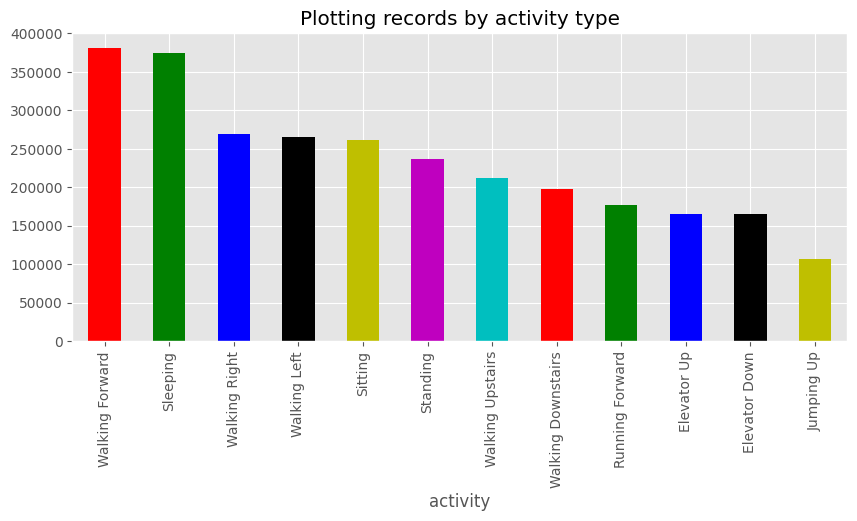

In [11]:
## check class districtions, and save fig to disk
df['activity'].value_counts().plot(kind='bar', color=['r','g','b','k','y','m','c'], title='Plotting records by activity type', figsize=(10, 4),align='center');
plt.savefig(plot_dir + 'sample_dist.pdf', bbox_inches='tight')

In [12]:
## print the value counts for each activity
print(df['activity'].value_counts())

activity
Walking Forward       381400
Sleeping              375000
Walking Right         269700
Walking Left          264600
Sitting               261500
Standing              236000
Walking Upstairs      211800
Walking Downstairs    197400
Running Forward       176500
Elevator Up           165491
Elevator Down         164999
Jumping Up            107100
Name: count, dtype: int64


In [13]:
## if you want to just read your saved df
# df = pd.read_pickle('data/df.pkl')

## UNCOMMENT below line for segmenting the signal in overlapping windows of 90 samples with 50% overlap
# segments, labels, subjects = segment_signal(df)

## COMMENT below segments + labels files if you want to segment afresh . open a file, where you stored the pickled data
segments = pickle.load(open('./data/segments_90_logo.p', 'rb'), encoding='latin1')
labels = pickle.load(open('./data/labels_90_logo.p','rb'), encoding='latin1')
subjects = pickle.load(open('./data/subjects_90_logo.p','rb'),encoding='latin1')

## dump information to that file (UNCOMMENT to save fresh segmentation!)
# pickle.dump(segments, open( './data/segments_90_logo.p','wb'))
# pickle.dump(labels, open( './data/labels_90_logo.p','wb'))
# pickle.dump(subjects, open( './data/subjects_90_logo.p','wb'))

# segments, labels, subjects = segment_signal(df)

### Check mismatch between sensor readings of dataset and Android sensors

In [ ]:
## USC-HAD dataset inspect

len_sample = len(df)

# print(df[df['activity'] == 'Sitting']['acc_x'])
usc_sit_df_acc_x = df[df['activity'] == 'Sitting']['acc_x'][0:len_sample]
usc_sit_df_acc_y = df[df['activity'] == 'Sitting']['acc_y'][0:len_sample]
usc_sit_df_acc_z = df[df['activity'] == 'Sitting']['acc_z'][0:len_sample]
usc_sit_df_gyr_x = df[df['activity'] == 'Sitting']['gyr_x'][0:len_sample]
usc_sit_df_gyr_y = df[df['activity'] == 'Sitting']['gyr_y'][0:len_sample]
usc_sit_df_gyr_z = df[df['activity'] == 'Sitting']['gyr_z'][0:len_sample]


print('sitting mean usc-had acc_x: '+ str(np.mean(usc_sit_df_acc_x)))
print('sitting std usc-had acc_x: '+ str(np.std(usc_sit_df_acc_x)))

print('sitting mean usc-had acc_y: '+ str(np.mean(usc_sit_df_acc_y)))
print('sitting std usc-had acc_y: '+ str(np.std(usc_sit_df_acc_y)))

print('sitting mean usc-had acc_z: '+ str(np.mean(usc_sit_df_acc_z)))
print('sitting std usc-had acc_z: '+ str(np.std(usc_sit_df_acc_z)))

print('sitting mean usc-had gyr_x: '+ str(np.mean(usc_sit_df_acc_z)))
print('sitting std usc-had gyr_x: '+ str(np.std(usc_sit_df_acc_z)))

print('sitting mean usc-had gyr_y: '+ str(np.mean(usc_sit_df_acc_z)))
print('sitting std usc-had gyr_y: '+ str(np.std(usc_sit_df_gyr_y)))

print('sitting mean usc-had gyr_z: '+ str(np.mean(usc_sit_df_gyr_z)))
print('sitting std usc-had gyr_z: '+ str(np.std(usc_sit_df_gyr_z)))


# print 'usc-had dataset acc_x sample for sitting activity: '+ str(np.mean(sit_df_acc_x))
plt.plot(usc_sit_df_acc_x)
plt.show()
plt.plot(usc_sit_df_acc_y)
plt.show()
plt.plot(usc_sit_df_acc_z)
plt.show()
plt.plot(usc_sit_df_gyr_x)
plt.show()
plt.plot(usc_sit_df_gyr_y)
plt.show()
plt.plot(usc_sit_df_gyr_z)
plt.show()

In [ ]:
## Android sensor reading samples inspect

acc_sit_android = pd.read_csv('./data/android_sitting_acc.csv')[100:400]
gyr_sit_android = pd.read_csv('./data/android_sitting_gyr.csv')[100:400]

sit_acc_x = acc_sit_android['X']
sit_acc_y = acc_sit_android['Y']
sit_acc_z = acc_sit_android['Z']
sit_gyr_x = gyr_sit_android['X']
sit_gyr_y = gyr_sit_android['Y']
sit_gyr_z = gyr_sit_android['Z']

print('sitting android acc_x size: '+ str(len(sit_acc_x)))

print('sitting mean android acc_x: '+ str(np.mean(sit_acc_x)))
print('sitting std android acc_x: '+ str(np.std(sit_acc_x)))

print('sitting mean android acc_y: '+ str(np.mean(sit_acc_y)))
print('sitting std android acc_y: '+ str(np.std(sit_acc_y)))

print('sitting mean android acc_z: '+ str(np.mean(sit_acc_z)))
print('sitting std android acc_z: '+ str(np.std(sit_acc_z)))

print('sitting mean android gyr_x: '+ str(np.mean(sit_gyr_x)))
print('sitting std android gyr_x: '+ str(np.std(sit_gyr_x)))

print('sitting mean android gyr_y: '+ str(np.mean(sit_gyr_y)))
print('sitting std android gyr_y: '+ str(np.std(sit_gyr_y)))

print('sitting mean android gyr_z: '+ str(np.mean(sit_gyr_z)))
print('sitting std android gyr_z: '+ str(np.std(sit_gyr_z)))


plt.plot(sit_acc_x)
plt.show()
plt.plot(sit_acc_y)
plt.show()
plt.plot(sit_acc_z)
plt.show()
plt.plot(sit_gyr_x)
plt.show()
plt.plot(sit_gyr_y)
plt.show()
plt.plot(sit_gyr_z)
plt.show()